In [40]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List

api = wandb.Api()
sns.set_style("whitegrid")
sns.set_context(
    "talk",
    font_scale=1.5
)
sns.set_palette(
    palette=sns.color_palette()
)

save_path = Path("/Users/alexanderlontke/Desktop")

In [2]:
def get_run_history(api: wandb.Api, project_name:str, run_name: str,):
    runs = api.runs(project_name)
    for run in runs:
        if run.name == run_name:
            return run.history()
    return None

def get_run_summary(api: wandb.Api, project_name:str, run_name: str,):
    runs = api.runs(project_name)
    for run in runs:
        if run.name == run_name:
            return run.summary
    return None

def match_name(name:str):
    nl = name.lower()
    if "simclr" in nl:
        return "SimCLR"
    elif "vae" in nl:
        return "VAE"
    elif "bigan" in nl:
        return "BiGAN"
    elif "random" in nl:
        return "Random Init"
    else:
        return None

def visualize_training_trajectory(
        run_history: pd.DataFrame,
        x_key:str ="trainer/global_step",
        y_key:str ="train/NTXentLoss_step",
        y_label:str = "Train NT-Xent Loss",
        x_label: str="Step",
):
    ax = sns.lineplot(
        data=run_history,
        y=y_key,
        x=x_key,

    )
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

## SimClr Training Trajectory ##

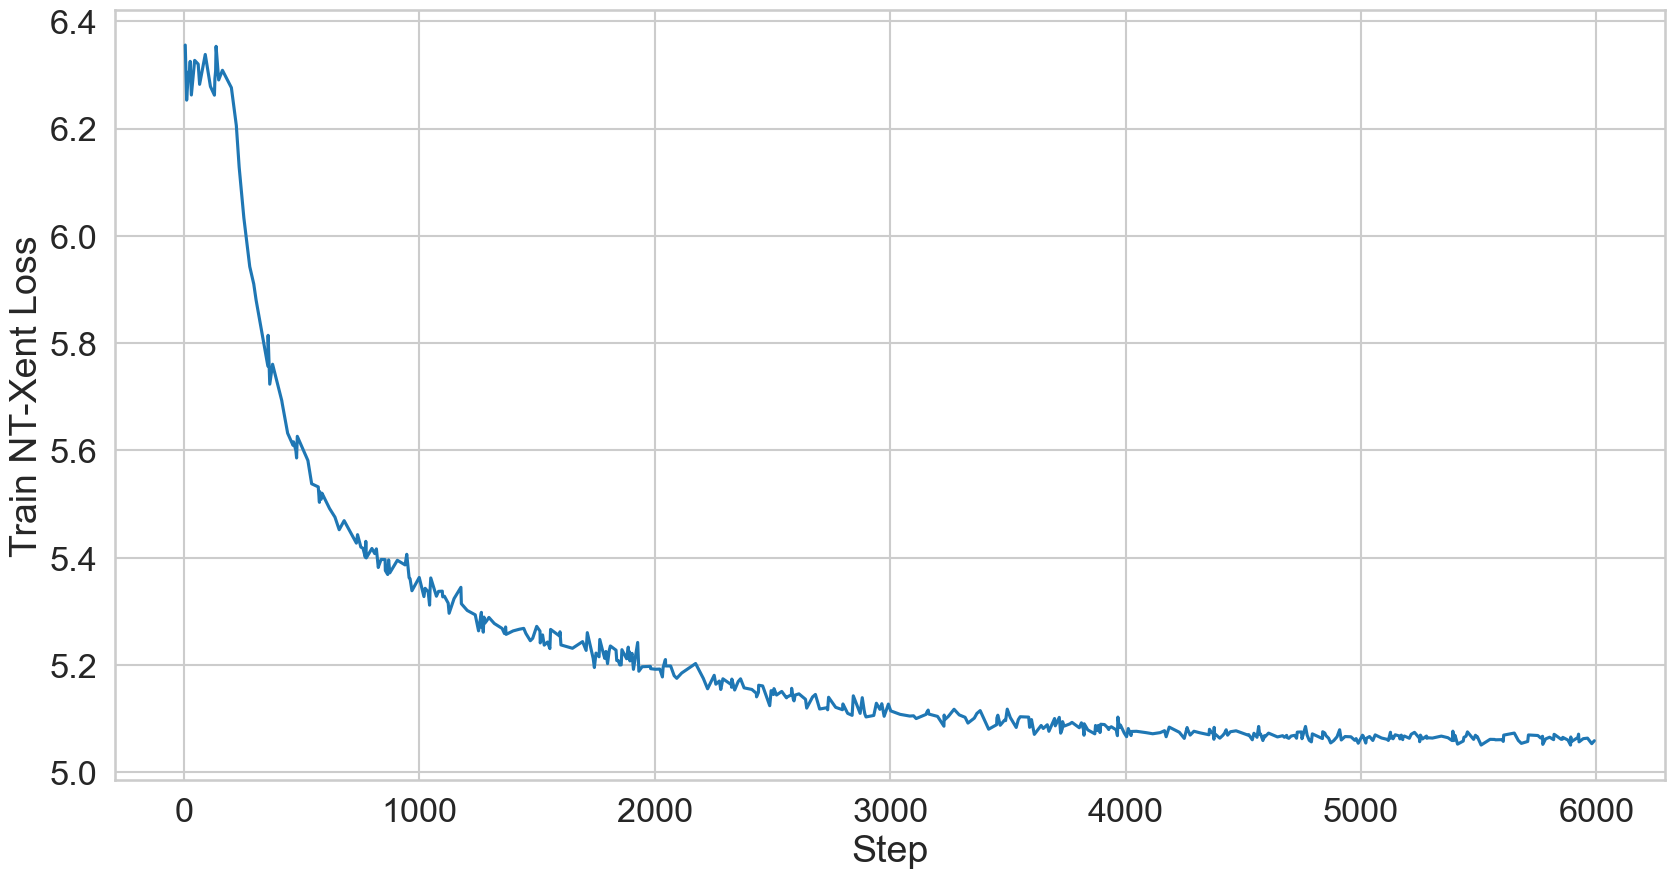

In [3]:
plt.figure(figsize=(20,10))
simclr_run_history = get_run_history(
    api=api,
    project_name= "alontke/ssl-remote-sensing-simclr",
    run_name="splendid-night-40"
)
visualize_training_trajectory(
    run_history=simclr_run_history,
)
plt.savefig(save_path / "simclr_training.png", bbox_inches="tight")

## Classification Downstream Task ##

In [47]:
run_names_of_interest = [
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_True_linear_True',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_True_linear_True',
    'random_lr_0.001_frozen_True_linear_True',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_True_linear_True',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_True_linear_False',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_True_linear_False',
    'random_lr_0.001_frozen_True_linear_False',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_True_linear_False',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_False_linear_True',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_False_linear_True',
    'random_lr_0.001_frozen_False_linear_True',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_False_linear_True',
    'SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_False_linear_False',
    'bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_False_linear_False',
    'random_lr_0.001_frozen_False_linear_False',
    'vae_bigearthnet.ckpt_lr_0.001_frozen_False_linear_False',
]

## Training Trajectories ##

In [48]:
def plot_classification_training_trajectories(run_names_of_interest, run_name_infix: Optional[str]= None, aggregate: str = "_step"):
    run_name_key ="run_name"
    classification_run_histories = []
    for run_name in run_names_of_interest:
        if not run_name_infix or run_name_infix in run_name:
            current_history = get_run_history(
                api=api,
                project_name="alontke/ssl-remote-sensing-classification",
                run_name=run_name
            )
            if current_history is None:
                print(run_name)
            current_history[run_name_key] = run_name
            classification_run_histories += [current_history]
    all_histories = pd.concat(classification_run_histories)
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))

    pivot_table = all_histories.pivot(
        index=aggregate,
        columns=run_name_key,
        values="step/training_loss"
    )
    for column in pivot_table.columns:
        sns.lineplot(
            data=pivot_table[column],
            ax=ax,
            label=match_name(column),
        )
    if aggregate == "_step":
        ax.set_xlabel("Step")
    elif aggregate == "_timestamp":
        ax.set_xlabel("Timestamp")
    ax.set_ylabel("Cross Entropy Loss")
    #ax.set_title(f"Training Trajectories (Infix: {infix})")

## Classification Accuracies ##

In [61]:
def plot_classification_accuracy(run_names_of_interest, run_name_infix: Optional[str]= None):
    plt.figure(figsize=(20, 15))
    run_name_to_viz = "Run Name"
    metric_to_viz = "Accuracy"
    metrics = {
        metric_to_viz: [],
        run_name_to_viz: [],
    }
    for run_name in run_names_of_interest:
        if not run_name_infix or run_name_infix in run_name:
            current_metric = get_run_summary(
                api=api,
                project_name="alontke/ssl-remote-sensing-classification",
                run_name=run_name
            )["classification_report"]["accuracy"]
            metrics[run_name_to_viz] += [match_name(run_name)]
            metrics[metric_to_viz] += [current_metric]
    print(metrics[run_name_to_viz])
    ax = sns.barplot(
        data=metrics,
        x=run_name_to_viz,
        y=metric_to_viz
    )
    #ax.set_title(f"Accuracy (Infix: {infix})")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Pre-Text Task")

## Frozen: True, Linear: True ##

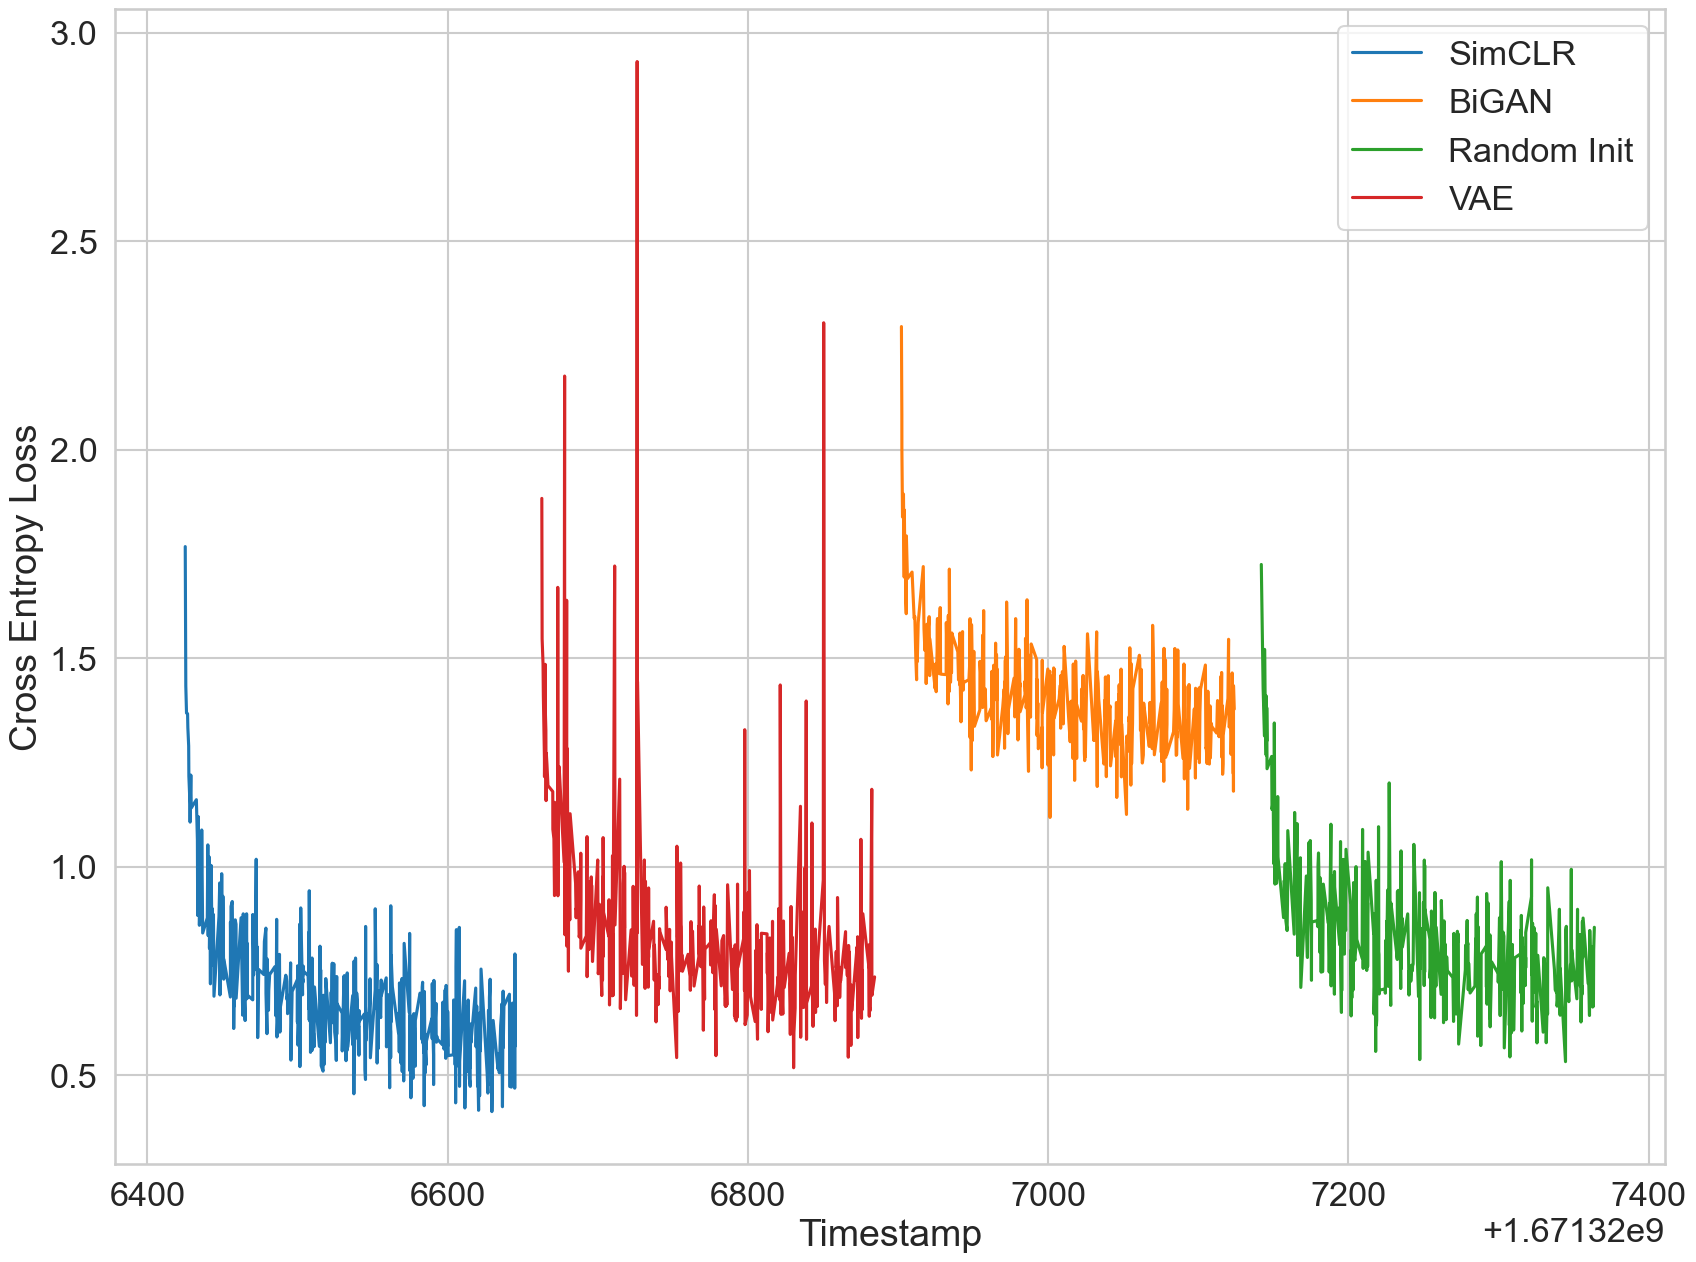

In [50]:
infix = "frozen_True_linear_True"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

['SimCLR', 'BiGAN', 'Random Init', 'VAE']


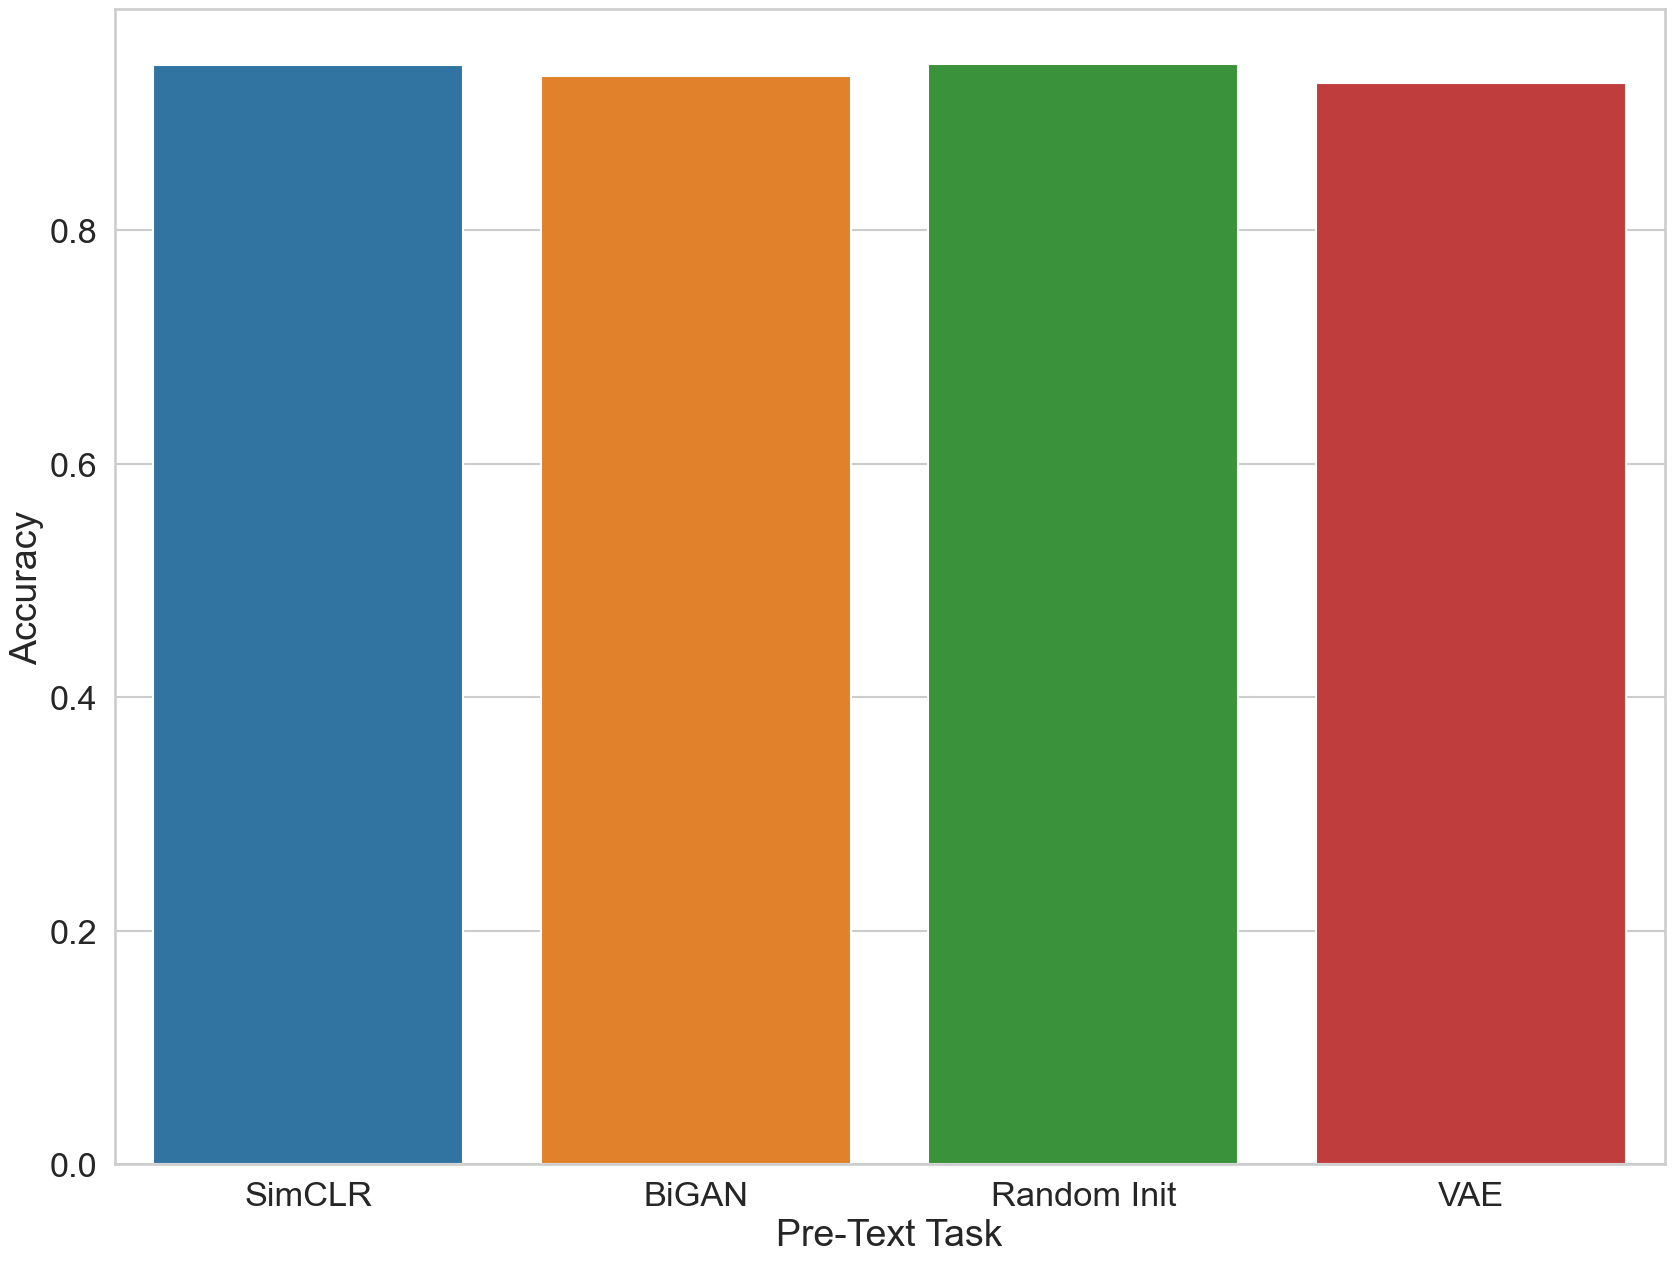

In [62]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: False, Linear: True ##

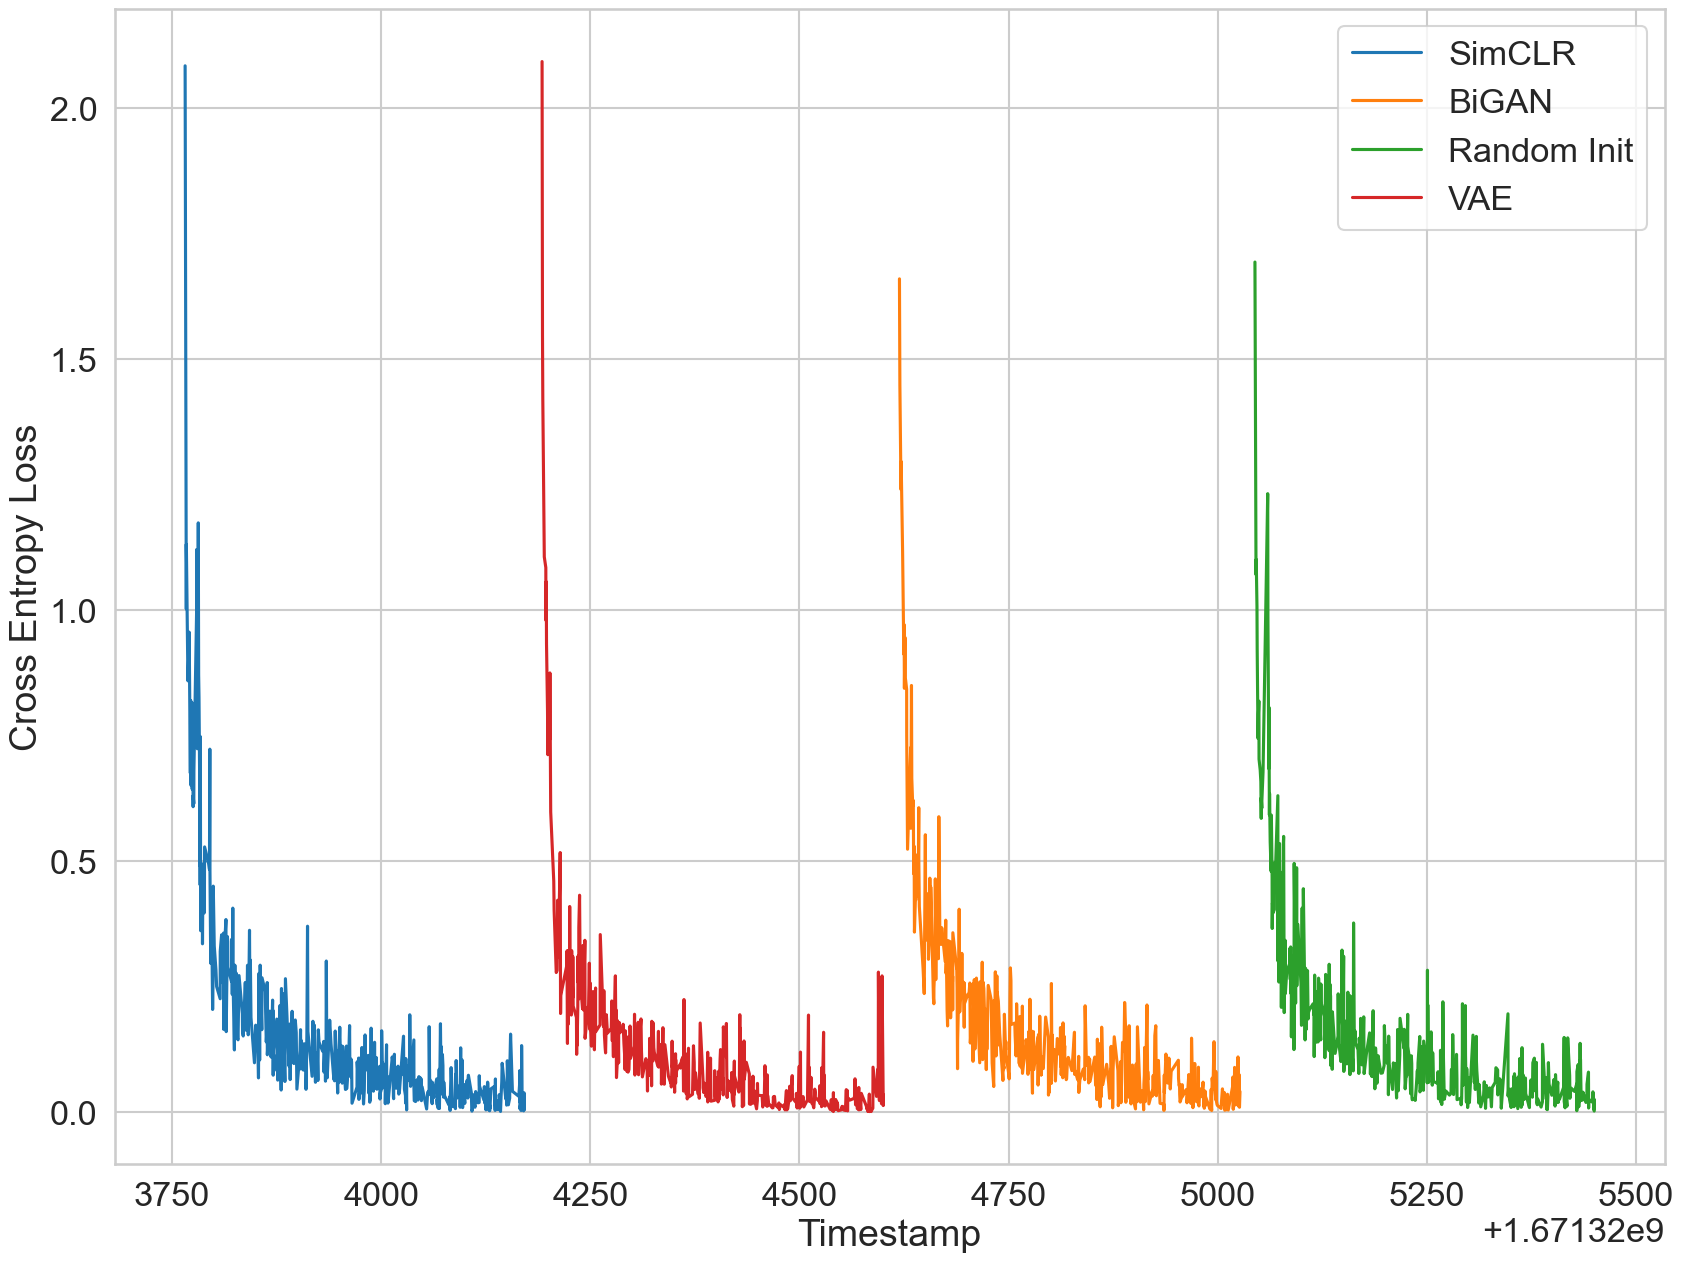

In [52]:
infix = "frozen_False_linear_True"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

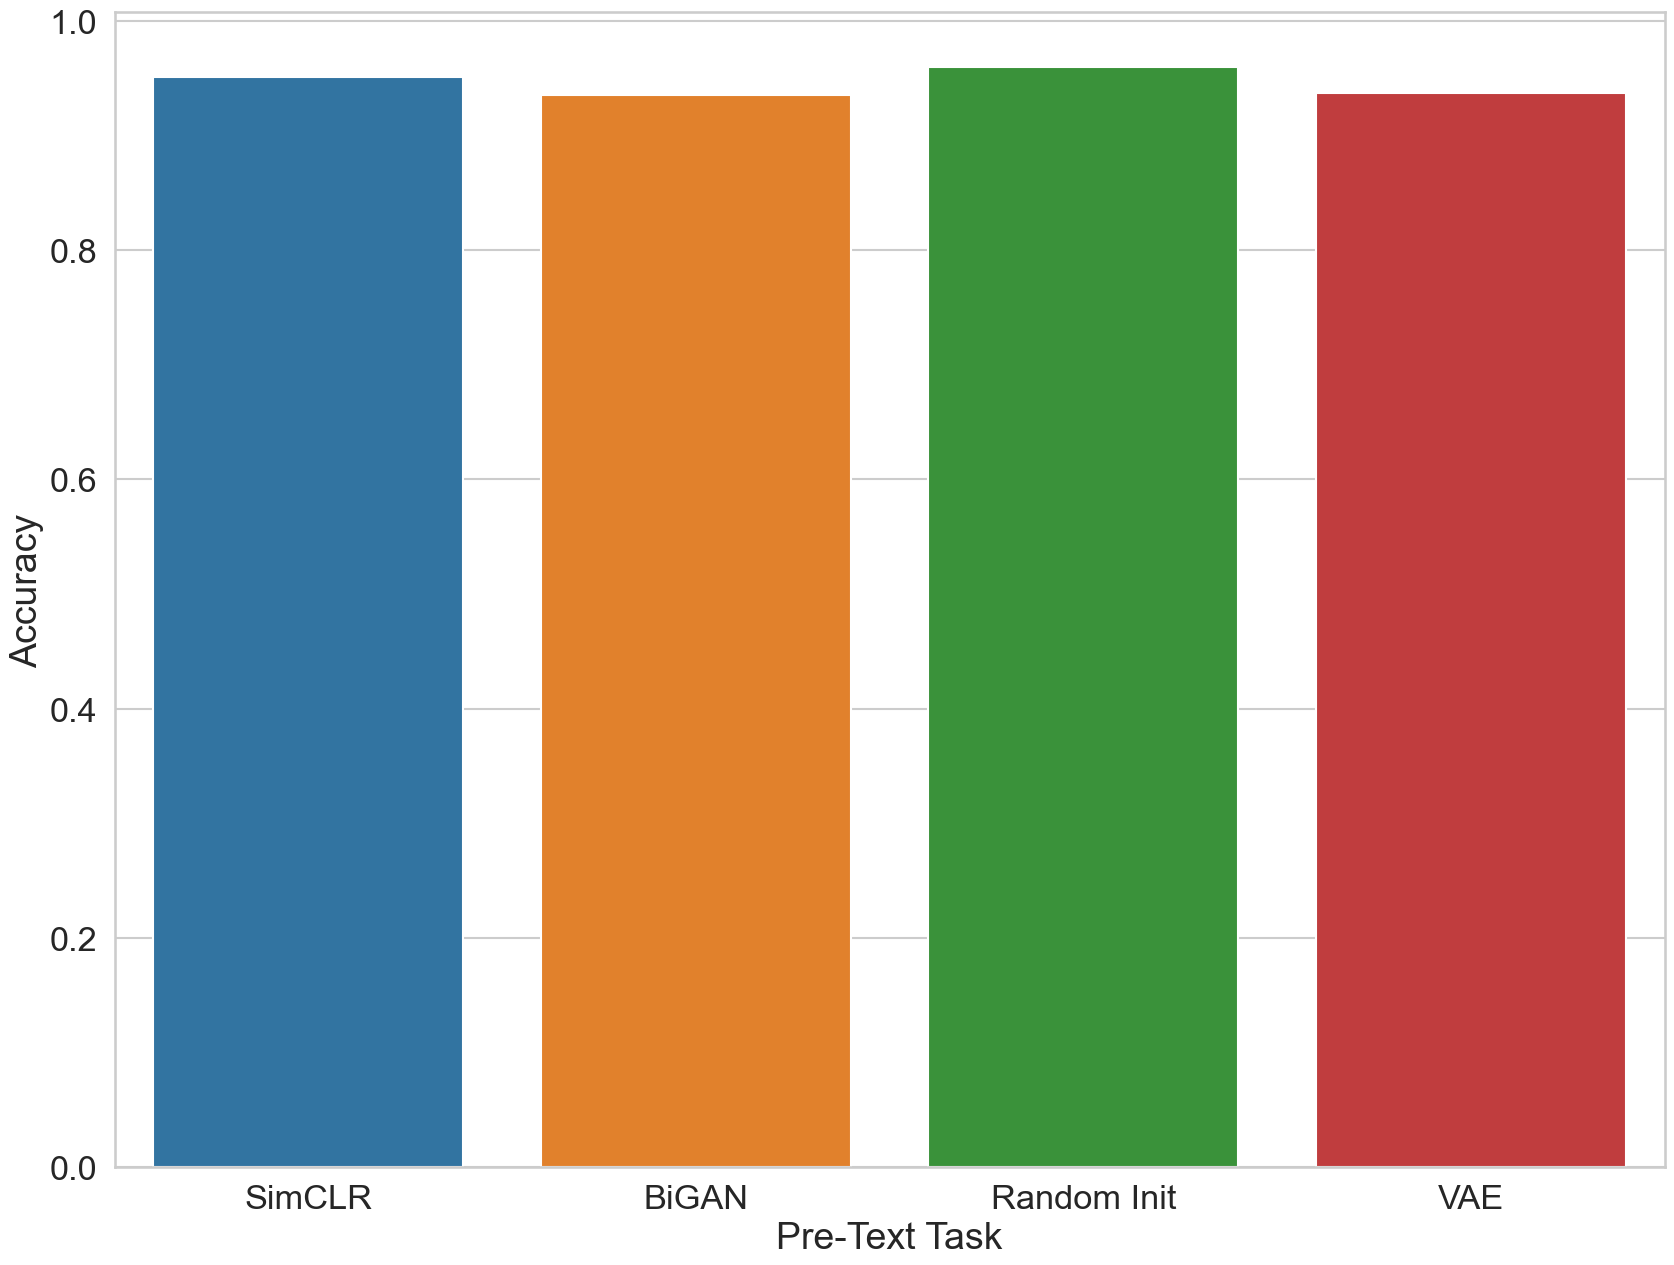

In [53]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: True, Linear: False ##

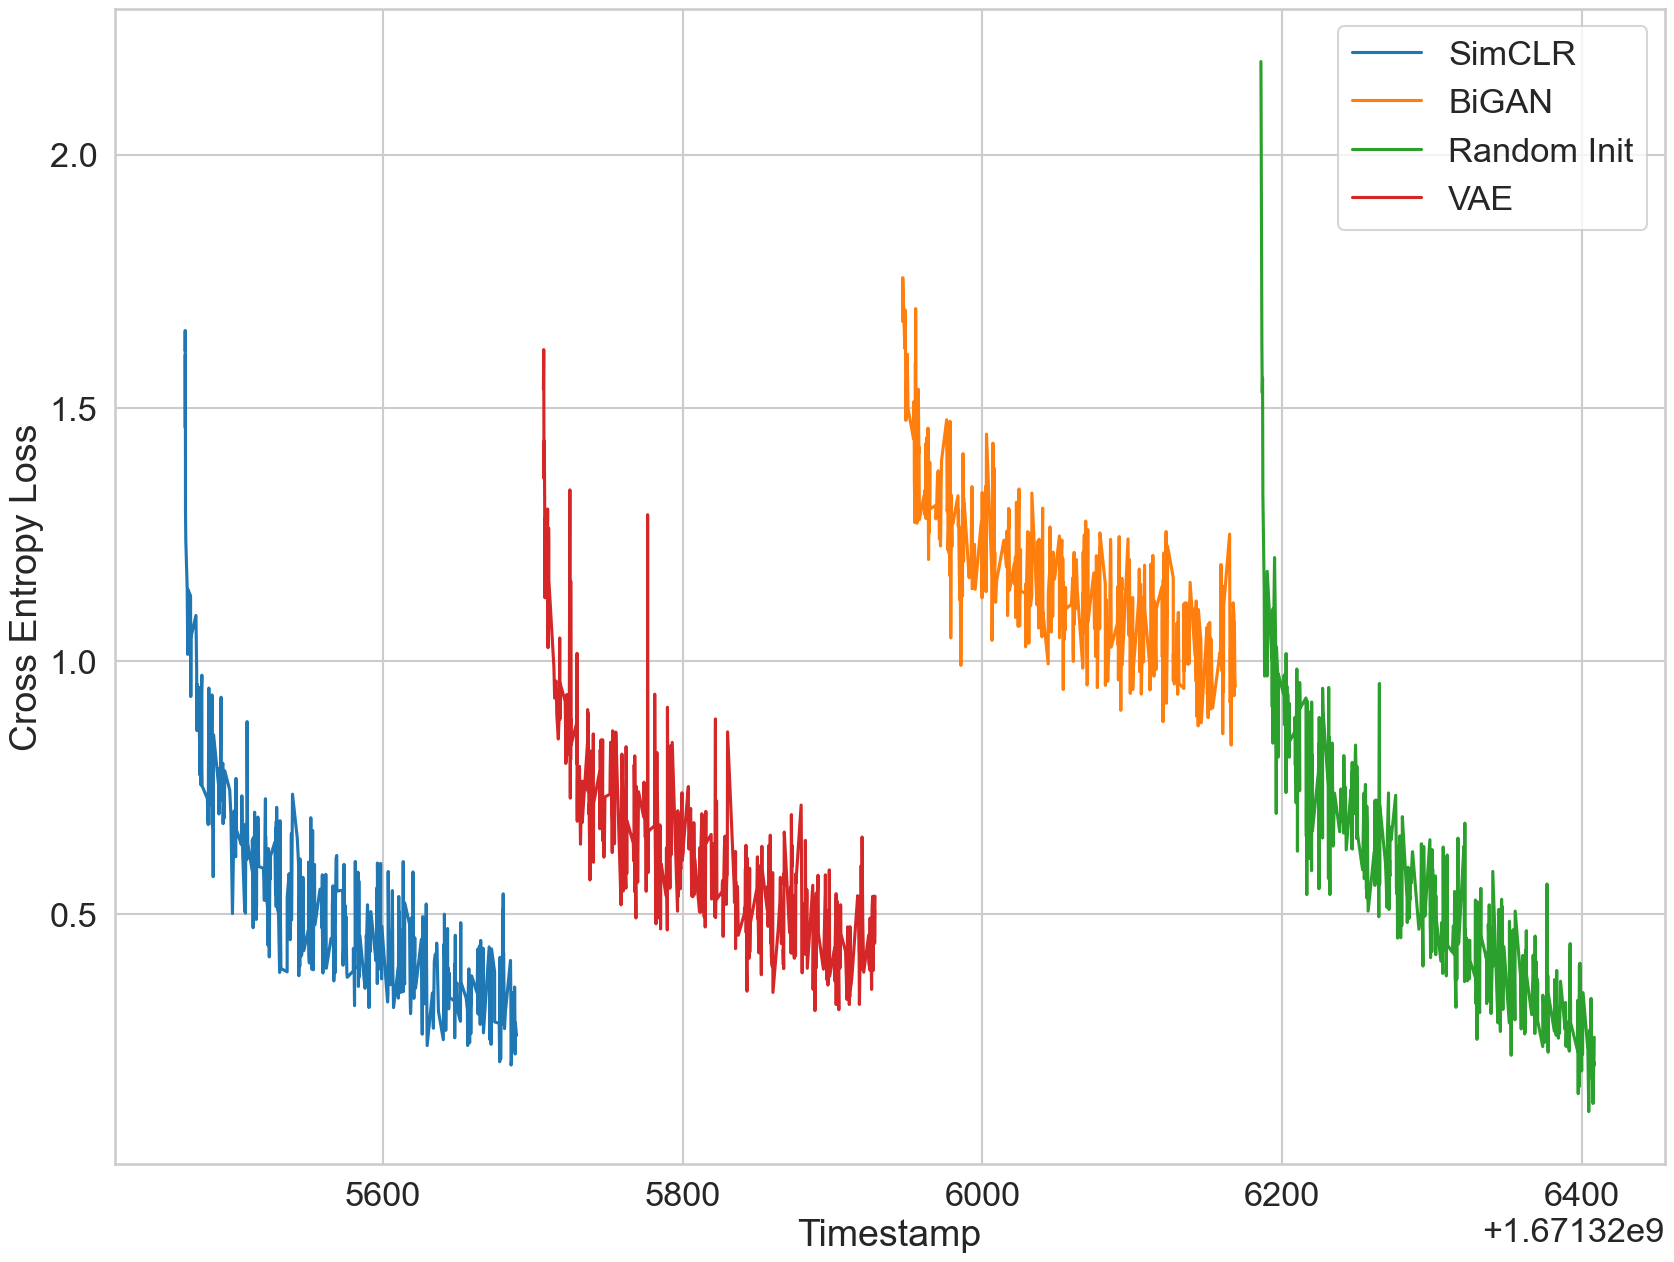

In [54]:
infix = "frozen_True_linear_False"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

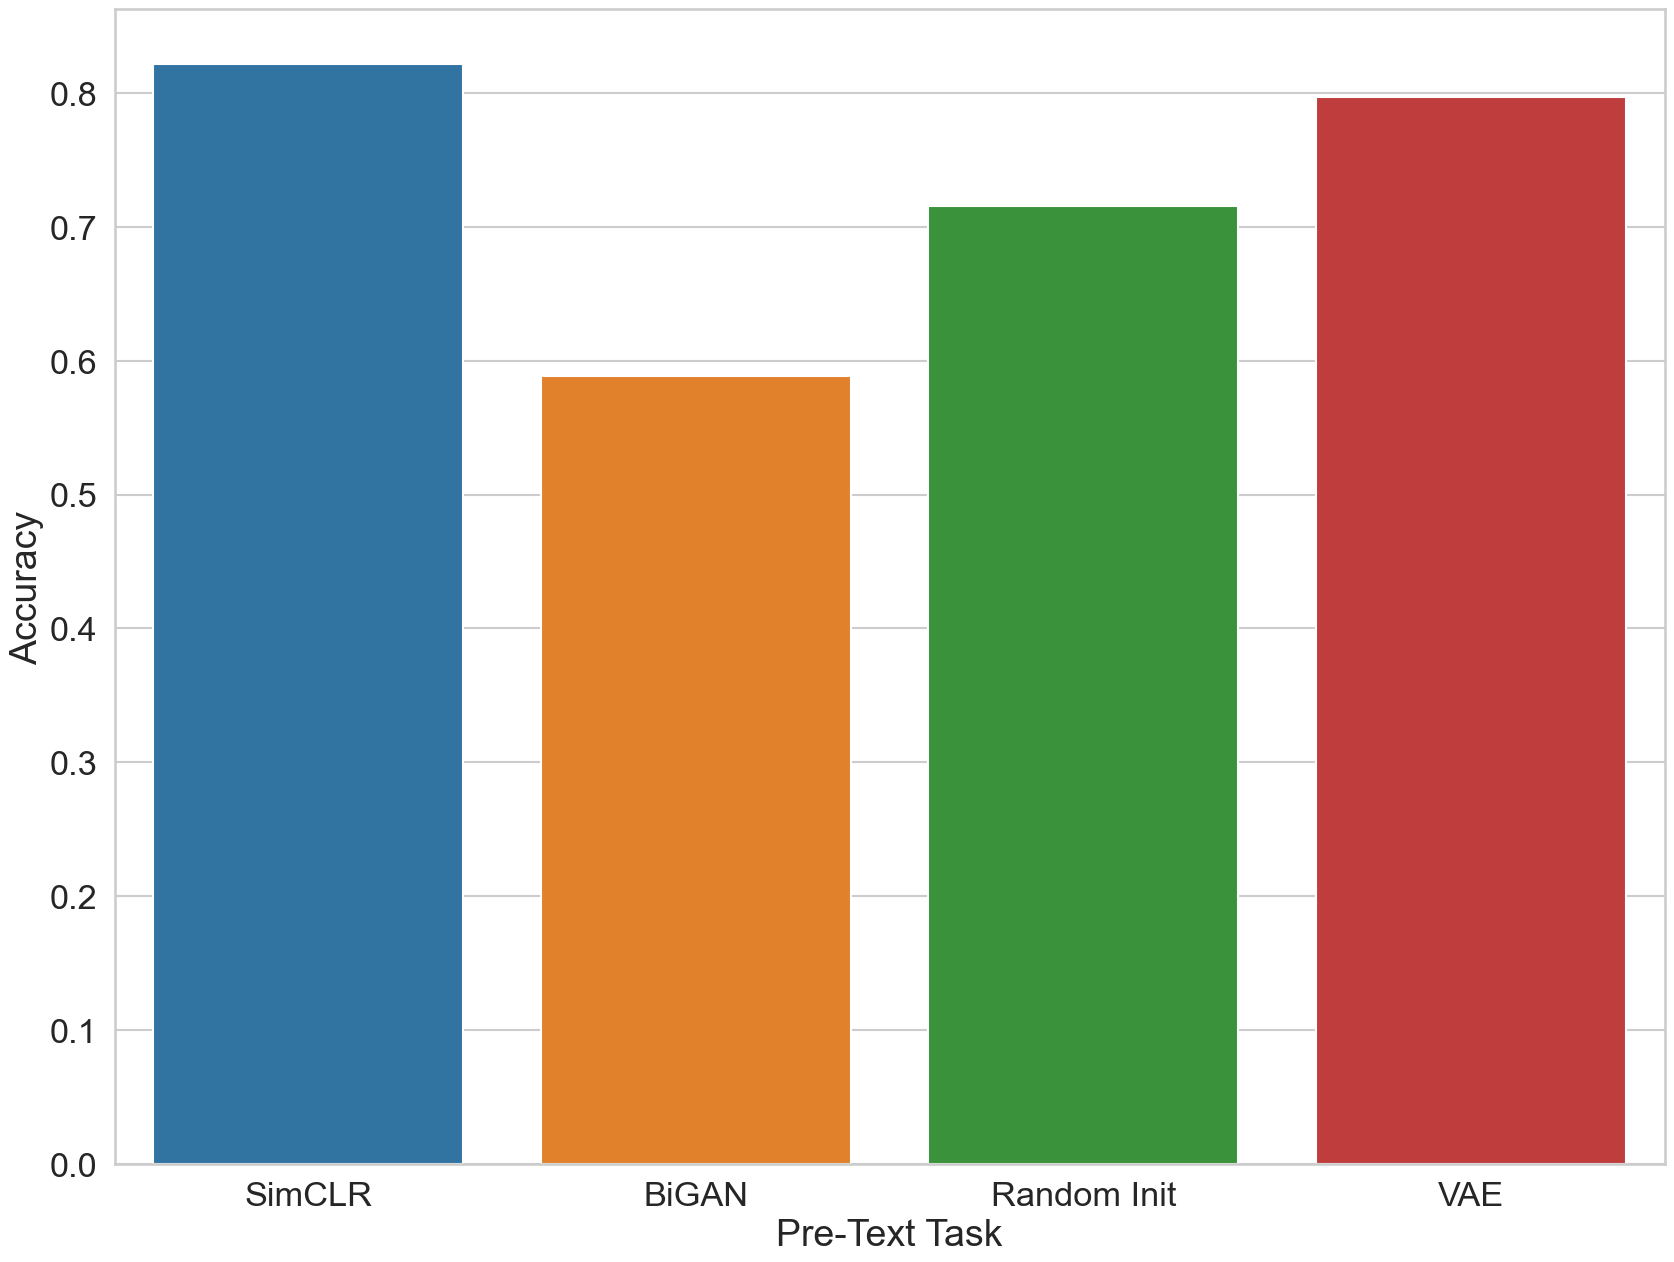

In [55]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: False, Linear: False ##

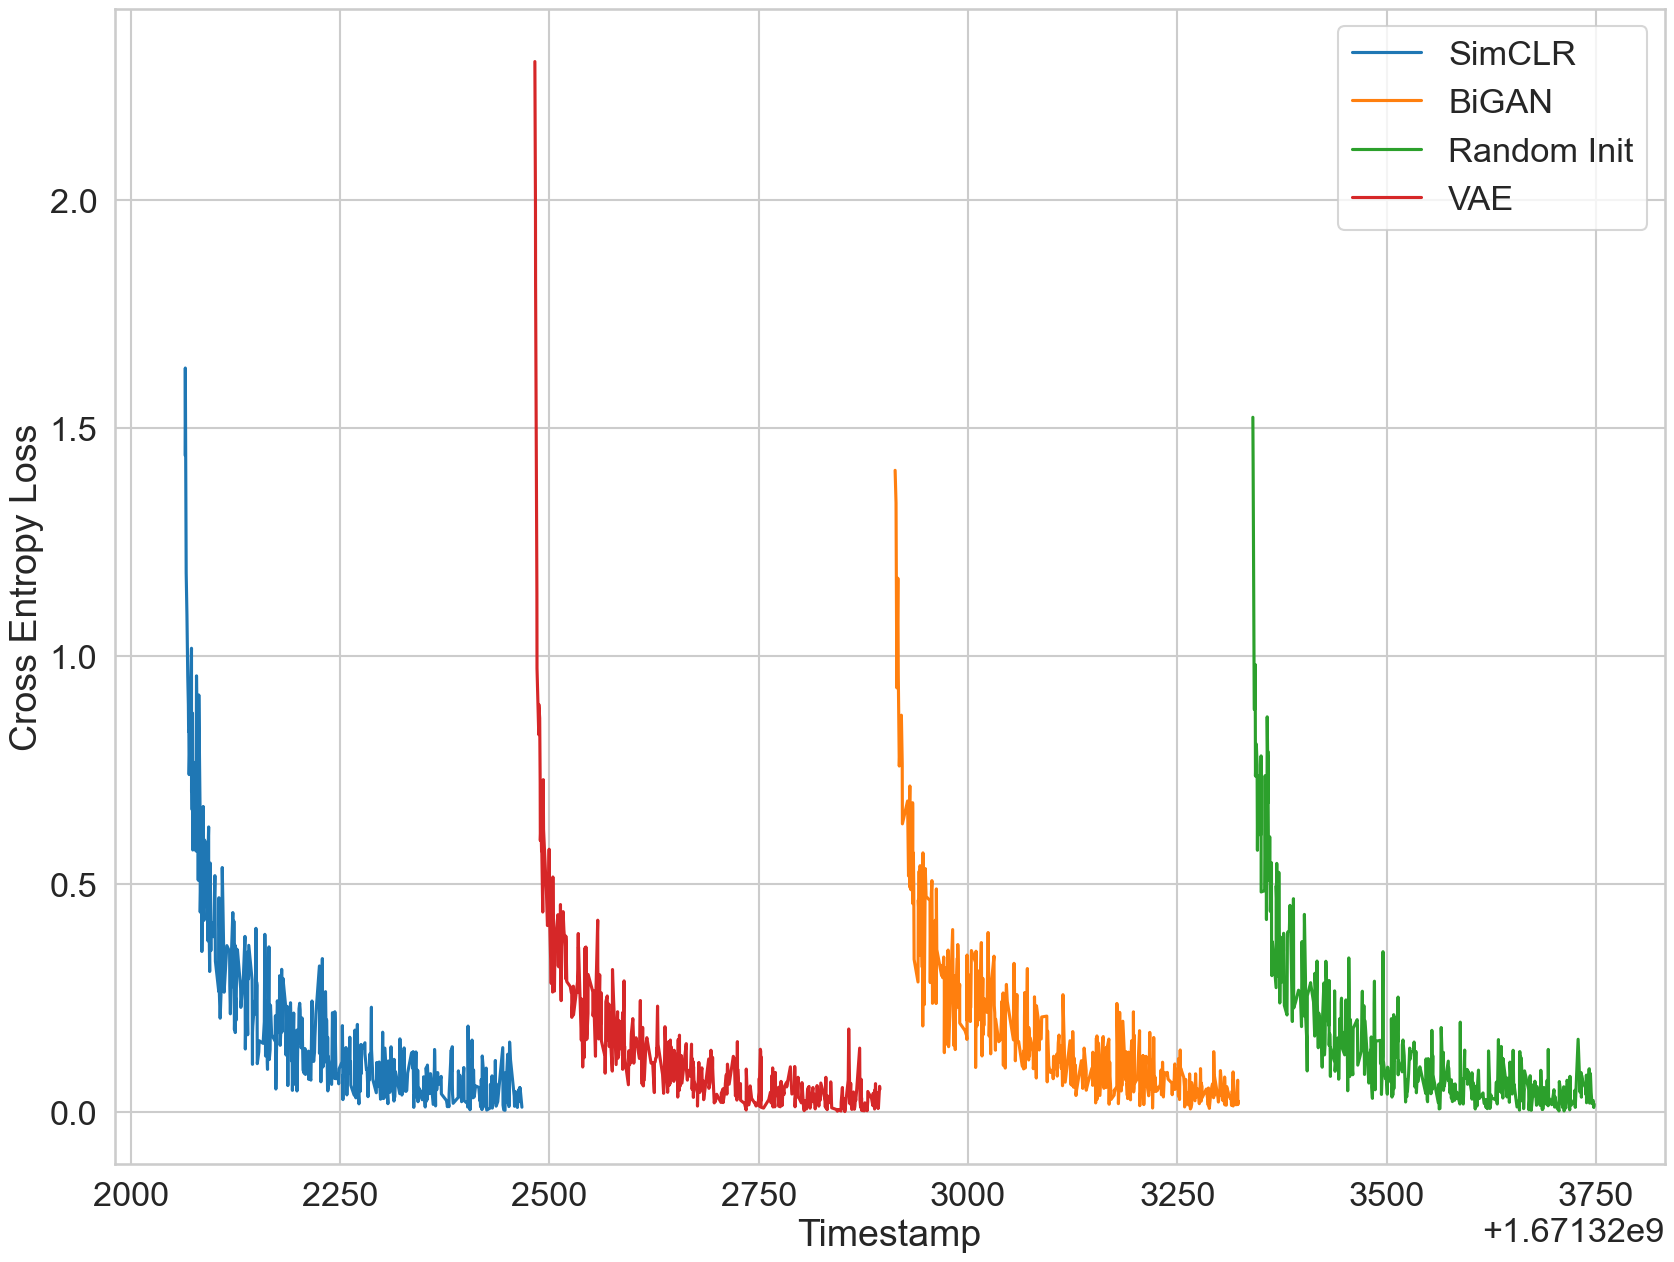

In [56]:
infix = "frozen_False_linear_False"
plot_classification_training_trajectories(run_names_of_interest, run_name_infix=infix, aggregate="_timestamp")
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

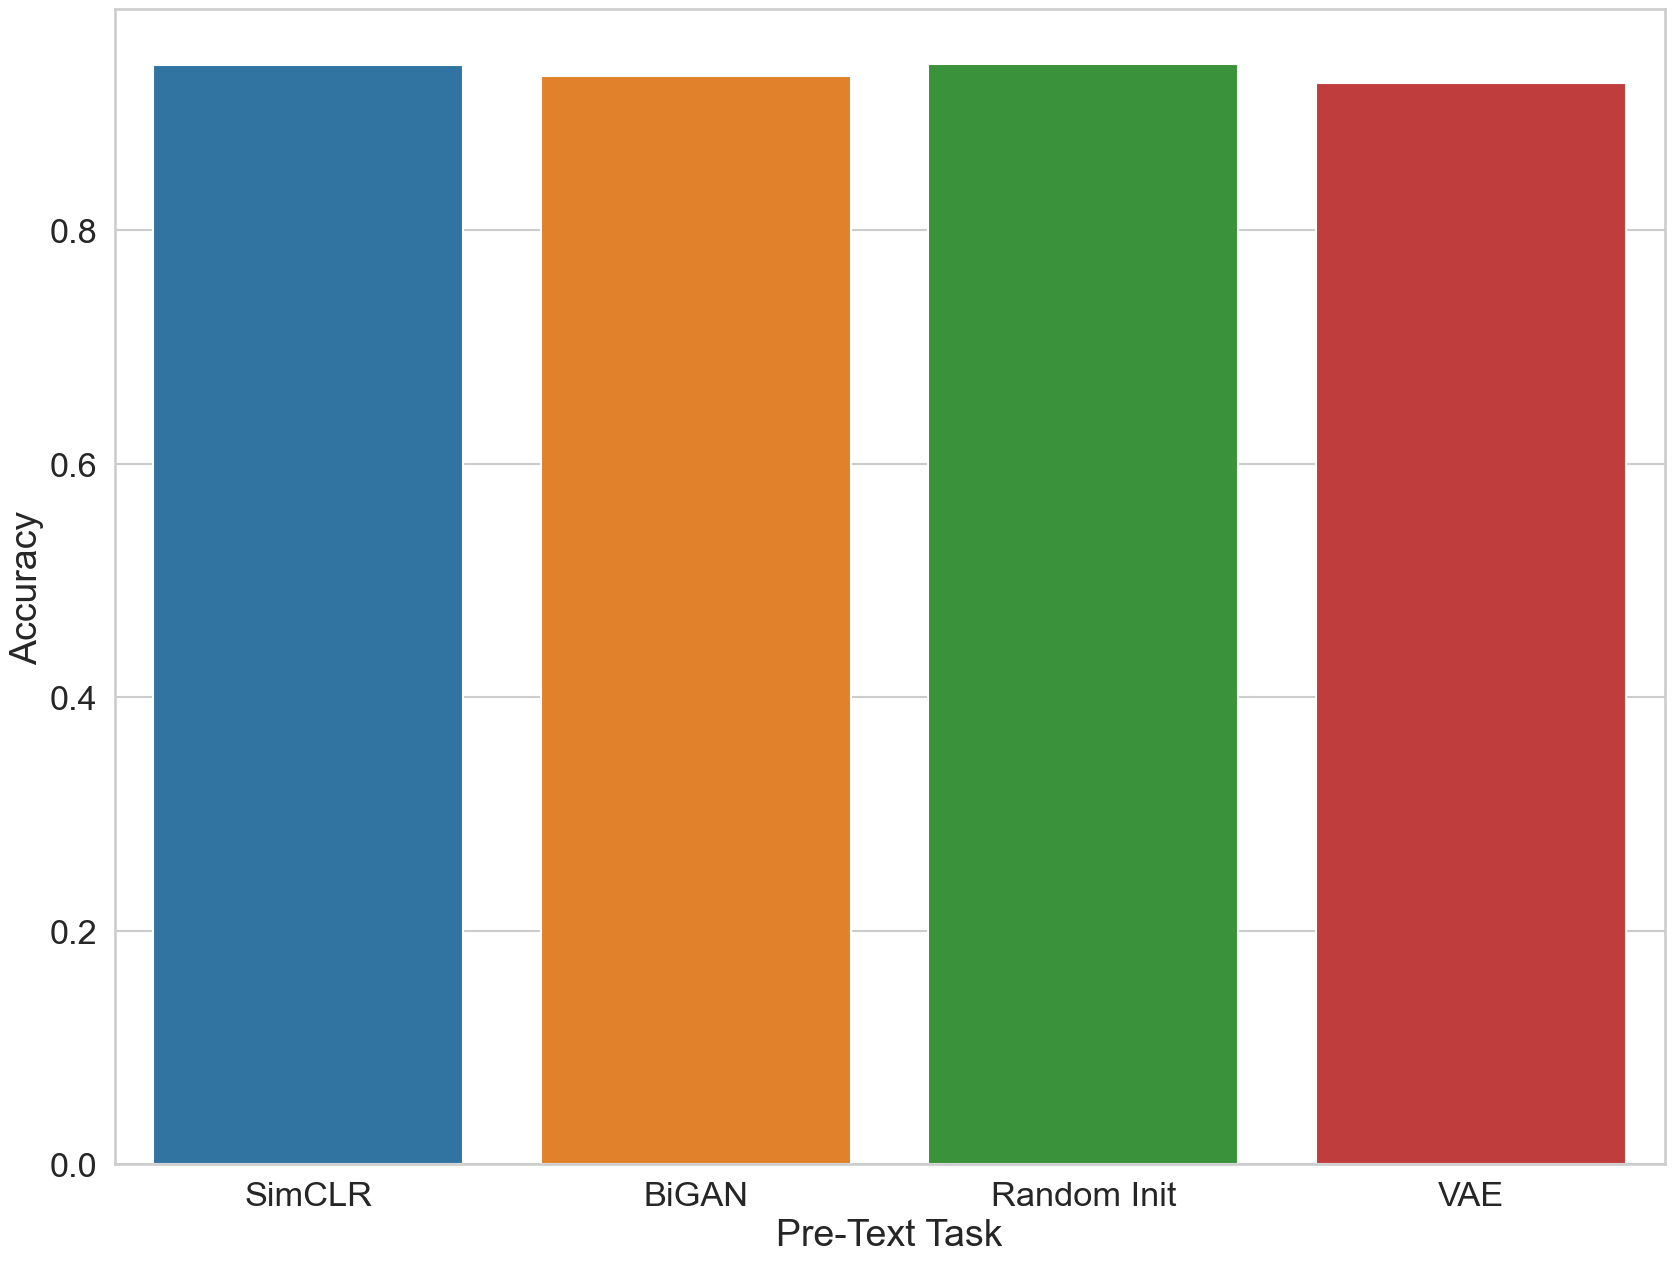

In [57]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

In [15]:
import matplotlib as mpl
font_paths = mpl.font_manager.findSystemFonts()
font_objects = mpl.font_manager.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)

AttributeError: module 'matplotlib.font_manager' has no attribute 'createFontList'

In [18]:
sorted(mpl.font_manager.get_font_names())

['.Aqua Kana',
 '.Keyboard',
 '.New York',
 '.SF Arabic',
 '.SF Compact',
 '.SF Compact Rounded',
 '.SF NS Mono',
 '.SF NS Rounded',
 'Academy Engraved LET',
 'Al Bayan',
 'Al Nile',
 'Al Tarikh',
 'American Typewriter',
 'Andale Mono',
 'Apple Braille',
 'Apple Chancery',
 'Apple SD Gothic Neo',
 'Apple Symbols',
 'AppleGothic',
 'AppleMyungjo',
 'Arial',
 'Arial Black',
 'Arial Hebrew',
 'Arial Narrow',
 'Arial Rounded MT Bold',
 'Arial Unicode MS',
 'Athelas',
 'Avenir',
 'Avenir Next',
 'Avenir Next Condensed',
 'Ayuthaya',
 'Baghdad',
 'Bangla MN',
 'Bangla Sangam MN',
 'Baskerville',
 'Beirut',
 'Big Caslon',
 'Bodoni 72',
 'Bodoni 72 Oldstyle',
 'Bodoni 72 Smallcaps',
 'Bodoni Ornaments',
 'Bradley Hand',
 'Brush Script MT',
 'Chalkboard',
 'Chalkboard SE',
 'Chalkduster',
 'Charter',
 'Cochin',
 'Comic Sans MS',
 'Copperplate',
 'Corsiva Hebrew',
 'Courier',
 'Courier New',
 'DIN Alternate',
 'DIN Condensed',
 'Damascus',
 'DecoType Naskh',
 'DejaVu Sans',
 'DejaVu Sans Display